<ipython-input-2-819a9cb4413e>:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_distancia = np.iinfo(np.int).max


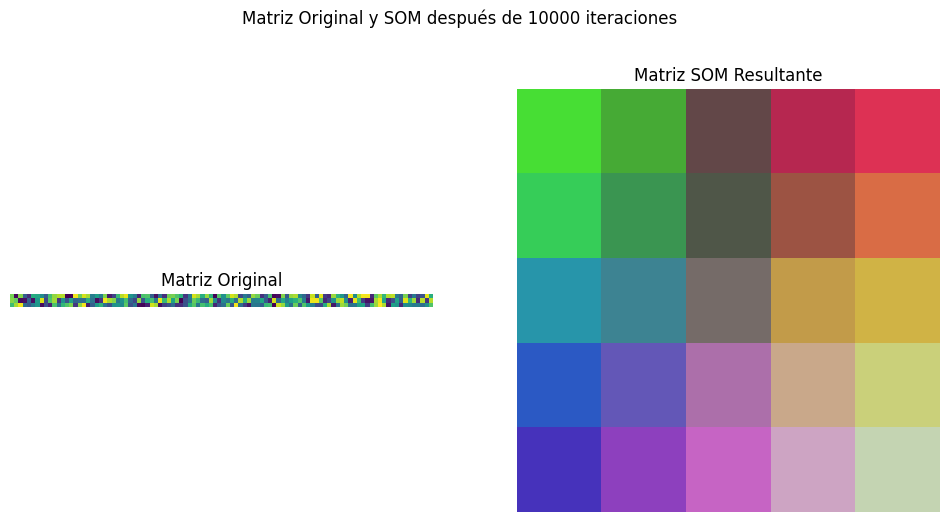

In [ ]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline
datos_crudos = np.random.randint(0, 255, (3, 100))
dimensiones_red = np.array([5, 5])
n_iteraciones = 10000
tasa_aprendizaje_inicial = 0.01

normalizar_datos = True
normalizar_por_columna = False
m = datos_crudos.shape[0]
n = datos_crudos.shape[1]

# radio vecindario inicial
radio_inicial = max(dimensiones_red[0], dimensiones_red[1]) / 2
# parámetro de decaimiento del radio
constante_temporal = n_iteraciones / np.log(radio_inicial)

datos = datos_crudos.copy()  # Hacer una copia de los datos originales
if normalizar_datos:
    if normalizar_por_columna:
        maximos_columnas = datos_crudos.max(axis=0)
        datos = datos_crudos / maximos_columnas[np.newaxis, :]
    else:
        datos = datos_crudos / datos_crudos.max()
red = np.random.random((dimensiones_red[0], dimensiones_red[1], m))


def encontrar_bmu(t, red, m):
    """
        Encuentra la Mejor Unidad Coincidente (BMU) para un vector dado, t
        Devuelve: bmu y bmu_idx, que es el índice de este vector en la SOM
    """
    bmu_idx = np.array([0, 0])
    min_distancia = np.iinfo(np.int).max

    # Calcula la distancia entre cada neurona y la entrada
    for x in range(red.shape[0]):
        for y in range(red.shape[1]):
            w = red[x, y, :].reshape(m, 1)
            distancia_cuadrada = np.sum((w - t) ** 2)
            distancia = np.sqrt(distancia_cuadrada)
            if distancia < min_distancia:
                min_distancia = distancia  # distancia mínima
                bmu_idx = np.array([x, y])  # índice

    bmu = red[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    return (bmu, bmu_idx)


def decaer_radio(radio_inicial, i, constante_temporal):
    return radio_inicial * np.exp(-i / constante_temporal)


def decaer_tasa_aprendizaje(tasa_aprendizaje_inicial, i, n_iteraciones):
    return tasa_aprendizaje_inicial * np.exp(-i / n_iteraciones)


def calcular_influencia(distancia, radio):
    return np.exp(-distancia / (2 * (radio ** 2)))


# Preparar la figura para mostrar ambas matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Matriz Original y SOM después de %d iteraciones' % n_iteraciones)

# Visualizar la matriz original (antes del entrenamiento)
axs[0].imshow(datos_crudos)
axs[0].set_title('Matriz Original')
axs[0].axis('off')

for i in range(n_iteraciones):
    # Selecciona un ejemplo de entrenamiento al azar
    t = datos[:, np.random.randint(0, n)].reshape(np.array([m, 1]))

    # Encuentra la Mejor Unidad Coincidente (BMU)
    bmu, bmu_idx = encontrar_bmu(t, red, m)

    # Decaimiento de parámetros SOM
    radio = decaer_radio(radio_inicial, i, constante_temporal)
    tasa_aprendizaje = decaer_tasa_aprendizaje(tasa_aprendizaje_inicial, i, n_iteraciones)

    # Actualiza el vector de pesos para acercarlo a la entrada
    # y acerca a sus vecinos en el espacio 2D
    for x in range(red.shape[0]):
        for y in range(red.shape[1]):
            w = red[x, y, :].reshape(m, 1)
            distancia_w = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            distancia_w = np.sqrt(distancia_w)

            if distancia_w <= radio:
                # Calcula el grado de influencia (basado en la distancia 2-D)
                influencia = calcular_influencia(distancia_w, radio)

                # Nuevo w = w antiguo + (tasa de aprendizaje * influencia * delta)
                # donde delta = vector de entrada (t) - w antiguo
                nuevo_w = w + (tasa_aprendizaje * influencia * (t - w))
                red[x, y, :] = nuevo_w.reshape(1, 3)

# Visualizar la matriz resultante (después del entrenamiento)
axs[1].imshow(red.reshape(dimensiones_red[0], dimensiones_red[1], m))
axs[1].set_title('Matriz SOM Resultante')
axs[1].axis('off')

plt.show()
